In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ompy as om
import logging
import pandas as pd
import json

import scipy as sp
#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


In [3]:
om.__full_version__;
np.random.seed(1382398)

In [4]:
plt.rcParams["figure.dpi"] = 80
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 25
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['text.usetex'] = True

Import $\gamma$SF and NLD from Oslo Method Software

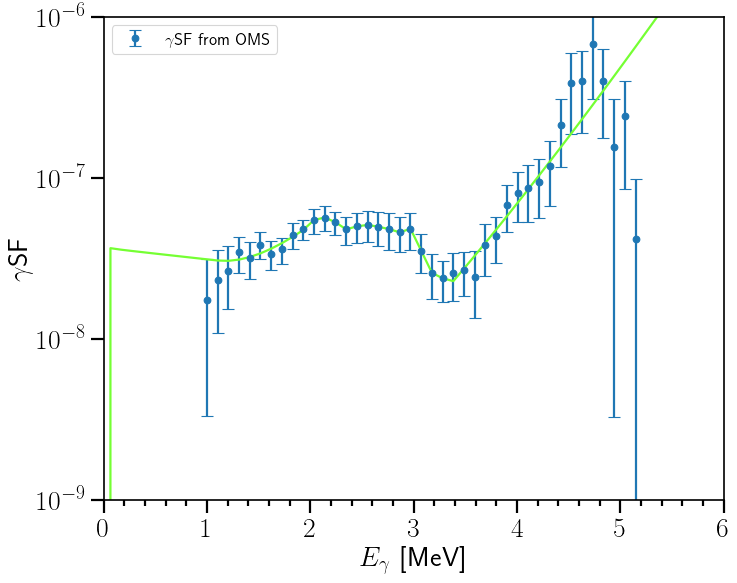

In [18]:
#reading files
OMS_path = 'analysis/OMS/02_FEB/'
#OMS_path = 'analysis/OMS/29_JAN_2/'

#My normalization
strength_nrm = np.genfromtxt(OMS_path+"strength.nrm") #experimental gamma strength function
discrete_levels = np.genfromtxt(OMS_path+"rholev.cnt") #Discrete levels 
rhopaw = np.genfromtxt(OMS_path+"rhopaw.cnt") #experimental level density
fermigas = np.genfromtxt(OMS_path+"fermigas.cnt") #fermi gas extrapolation of nld
trans_raw = np.genfromtxt(OMS_path+"transext.nrm") #gsf extrapolation
fg_theo_file = OMS_path+'fgteo.rsg'
fg_exp_file = OMS_path+'fg.rsg'
fg_exp_err_file = OMS_path+'fgerr.rsg'

#splitting arrays into data and errors
strength_nrm_split = np.array_split(strength_nrm,2)
gsf_OMS = strength_nrm_split[0] #OMS = Oslo Method Software
gsf_OMS_error = strength_nrm_split[1]

rhopaw_split = np.array_split(rhopaw, 2)
nld_OMS = rhopaw_split[0]
nld_OMS_error = rhopaw_split[1]

#variables for this experiment
a0 = -0.8671 #calibration constants
a1 = 0.1037
Sn = 5.762
rhoSn = 28.07e6
rhoSn_error = 7.02e6
Eg_min = 999.9
Eg_max = 5252

#making energy array for gsf
n_gsf = len(gsf_OMS)
energy_gsf_OMS = np.zeros(n_gsf)
for i in range(n_gsf):
    energy_gsf_OMS[i] = a0 + a1*i

#making energy array for nld
n_fermi = len(fermigas)
energy_nld_OMS = np.zeros(n_fermi)
for i in range(n_fermi):
    energy_nld_OMS[i] = a0 + a1*i

#finding cutting index for plotting CT extrapolation
n0_CT = np.argmin(abs(energy_nld_OMS-3.0))
n1_CT = np.argmin(abs(energy_nld_OMS-Sn-0.5))

n_trans_raw=len(trans_raw)
gsf_extrapolation=np.zeros(n_trans_raw)
energy_gsf_extrapolation=np.zeros(n_trans_raw)
for i in range(n_trans_raw):
    energy_gsf_extrapolation[i] = a0 + a1*i
    gsf_extrapolation[i] = trans_raw[i]/(2*3.14*energy_gsf_extrapolation[i]**3)
    

fig, ax = plt.subplots()

#OMS-analysis
ax.errorbar(x=energy_gsf_OMS, y=gsf_OMS, yerr=gsf_OMS_error, marker='o', linestyle='', label=' $\gamma$SF from OMS')

#extrapolation from OMS-analysis
plt.plot(energy_gsf_extrapolation[:80], gsf_extrapolation[:80], color="#75FF33")

ax.set_ylim(1e-9, 1e-6)
ax.set_xlim(0, 6)
ax.set_yscale('log')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('$E_\gamma$  [MeV]')
ax.set_ylabel('$\gamma$SF')
ax.legend(fontsize=15)

fig.show()


"Does_it_work.cpp" 

Script to check the quality of the extracted
level density and strength function
by plotting exp. and calculated f.g. spectra
written by: ACL. June 7, 2012
Translated to Python 2021 (tellefs)

IndexError: index 0 is out of bounds for axis 0 with size 0

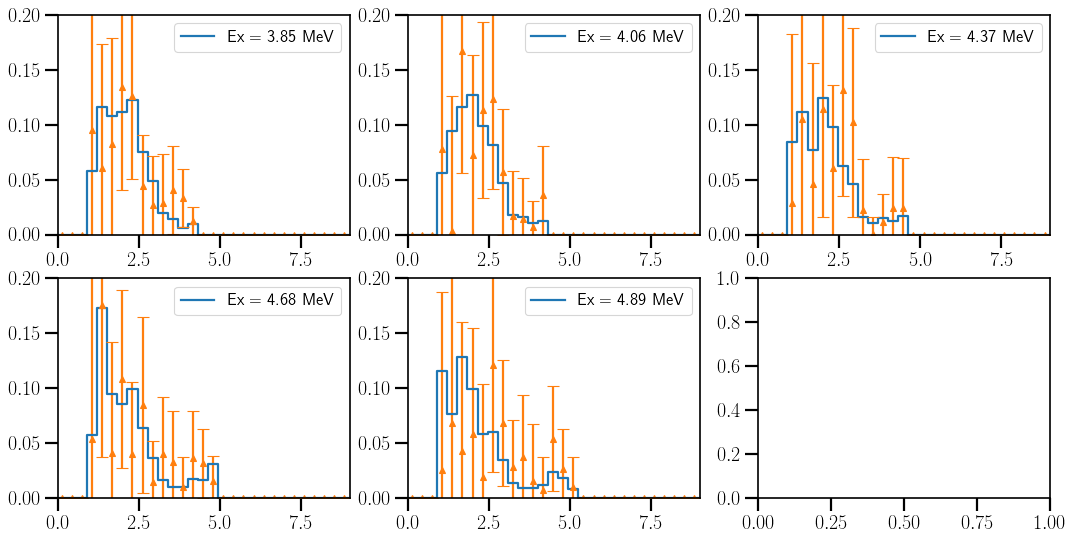

In [5]:
#set new rcParams. Need to reset after script to keep settings during program,
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams['font.size'] = 18


def read_rsg(filename):
    infile = open(filename, 'r')
    matrix = []
    
    #extract calibration parameters:
    count = 0
    for line in infile:
        values = line.split()
        if not(values):
            count +=1
            continue
        elif line.startswith('!CALIBRATION'):
            values = line.split(',')
            x_cal = values[1:4]
            y_cal = values[4:7]
            for i in range(len(x_cal)):
                x_cal[i] = float(x_cal[i])*1e-3 #convert to float, convert from keV to MeV
                y_cal[i] = float(y_cal[i])*1e-3
            count+=1
        elif line.startswith('!DIMENSION'):
            values = line.split(':')
            x_dim = int(values[1].split(',')[0])
            y_dim = int(values[2])
            count+=1
        elif line.startswith('!'):
            count +=1
            continue
        else:
            for i in range(len(values)):
                values[i] = float(values[i])
            matrix.append(values)
            count +=1
            
    matrix = om.Matrix(matrix)
    
    infile.close()
    return matrix, x_cal, y_cal, x_dim, y_dim

fg_exp, x_cal_exp, y_cal_exp, x_dim_exp, y_dim_exp= read_rsg(fg_exp_file)
fg_exp_error, x_cal_exp_error, y_cal_exp_error, x_dim_exp_error, y_dim_exp_error = read_rsg(fg_exp_err_file)
fg_theo, x_cal_theo, y_cal_theo, x_dim_theo, y_dim_theo = read_rsg(fg_theo_file)

bin1, bin2, bin3, bin4, bin5, bin6 = 13, 14, 15, 16, 17, 18

bins = [45, 47, 50, 53, 55, 59,]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(bins)):
    bin_no = bins[i]
    fg_theo_copy = fg_theo.copy()
    fg_theo_copy.cut('Ex', bin_no, bin_no+2)
    fg_theo_copy.Eg = x_cal_theo[0] + x_cal_theo[1]*fg_theo_copy.Eg + x_cal_theo[2]*fg_theo_copy.Eg**2
    fg_theo_copy.Ex = y_cal_theo[0] + y_cal_theo[1]*fg_theo_copy.Ex + y_cal_theo[2]*fg_theo_copy.Ex**2
    theo_y, theo_x = fg_theo_copy.projection('Eg')
    
    
    fg_exp_copy = fg_exp.copy()
    fg_exp_copy.cut('Ex', bin_no, bin_no+2)
    fg_exp_copy.Eg = x_cal_exp[0] + x_cal_exp[1]*fg_exp_copy.Eg + x_cal_exp[2]*fg_exp_copy.Eg**2
    fg_exp_copy.Ex = y_cal_exp[0] + y_cal_exp[1]*fg_exp_copy.Ex + y_cal_exp[2]*fg_exp_copy.Ex**2
    exp_y, exp_x = fg_exp_copy.projection('Eg');
    
    fg_exp_error_copy = fg_exp_error.copy()
    fg_exp_error_copy.cut('Ex', bin_no, bin_no+2)
    fg_exp_error_copy.Eg = x_cal_exp_error[0] + x_cal_exp_error[1]*fg_exp_error_copy.Eg + x_cal_exp_error[2]*fg_exp_error_copy.Eg**2
    fg_exp_error_copy.Ex = y_cal_exp_error[0] + y_cal_exp_error[1]*fg_exp_copy.Ex + y_cal_exp_error[2]*fg_exp_error_copy.Ex**2
    exp_err_y, exp_err_x = fg_exp_error_copy.projection('Eg');
    
    #cut arrays to show lesser points
    theo_y = theo_y[0:-1:3]
    theo_x = theo_x[0:-1:3]
    exp_y = exp_y[0:-1:3]
    exp_x = exp_x[0:-1:3]
    exp_err_y = exp_err_y[0:-1:3]
    exp_err_x = exp_err_x[0:-1:3]
    
    current_Ex = y_cal_theo[0] + y_cal_theo[1]*(bin_no+0.5) + y_cal_theo[2]*(bin_no+0.5)**2
    axes[i].step(theo_x, theo_y, where='mid', label='Ex = %.2f MeV'%current_Ex)
    
    
    axes[i].errorbar(exp_x, exp_y, yerr=exp_err_y, marker='^', linestyle='')
    axes[i].legend(fontsize=15)
    
    
    
    axes[i].set_xlim(0, 9)
    axes[i].set_ylim(0, 0.2)
    
fig.show()


#reset rcParams
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 25

Import $\gamma$SF and NLD from OMPy

In [10]:
def read_OMPy(datetime):
    """
    Read data from read_write_OMPy() function in OMPy analysis.
    as well as parameters from the README.txt file
    
    Values stored in value_array:
    value_array = [energy_gsf, gsf_median, gsf_error, 
                    energy_nld, nld_median, nld_error,
                    keV_per_bin, Ex_min, Ex_max, Eg_min,
                    Eg_max, Gg, Gg_err, rhoSn, rhoSn_err]
    """
    path = 'analysis/OMPy/normalized_data/U233_2021-'+datetime+'/data_for_analysis.csv'
    dataFrame = pd.read_csv(path)
    return dataFrame


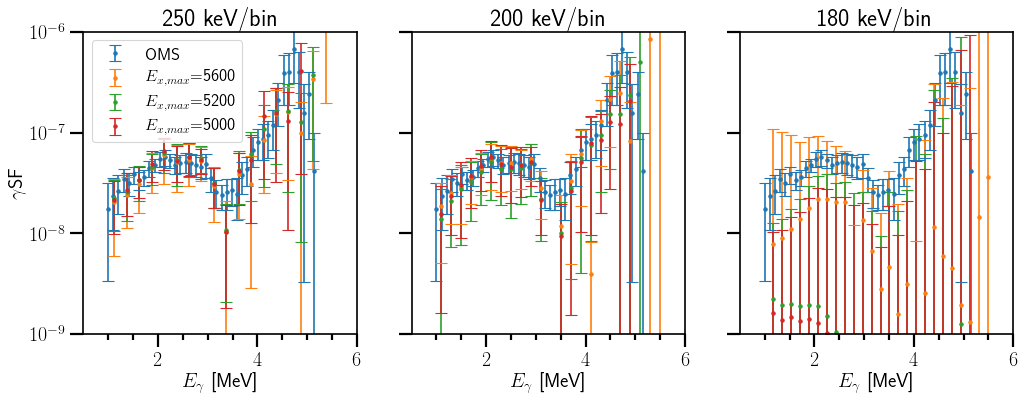

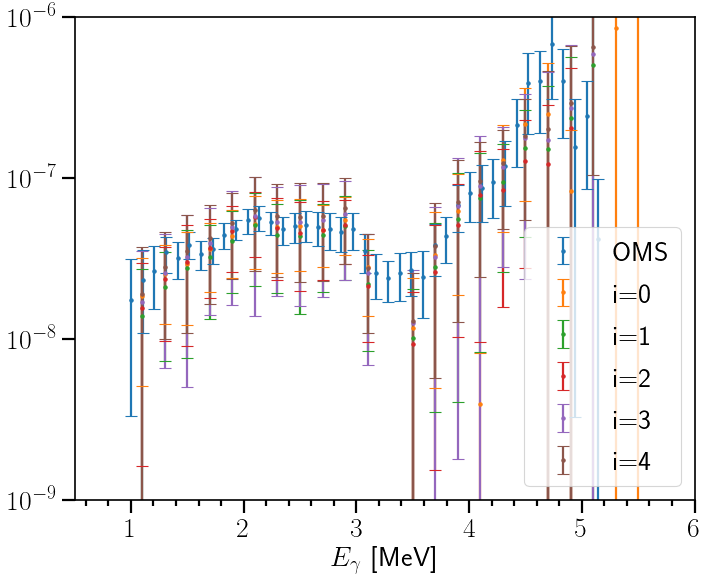

In [19]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 1.5

fig, (ax_250, ax_200, ax_180) = plt.subplots(1,3)
axes = [ax_250, ax_200, ax_180]
titles = ['250 keV/bin', '200 keV/bin', '180 keV/bin']

#extract OMPy data via function above
datetimes_250 = ['01-27_07:47:14', '01-26_20:27:09', '01-26_22:11:04']
datetimes_200 = ['01-26_18:54:24', '01-26_13:02:13', '01-26_17:31:53']
datetimes_180 = ['01-27_09:39:00', '01-27_11:13:55', '01-27_13:25:57']
Exmax_list = [5600, 5200, 5000]

ax_250.errorbar(x=energy_gsf_OMS, y=gsf_OMS, yerr=gsf_OMS_error, marker='.', linestyle='', label='OMS')
ax_200.errorbar(x=energy_gsf_OMS, y=gsf_OMS, yerr=gsf_OMS_error, marker='.', linestyle='', label='OMS')
ax_180.errorbar(x=energy_gsf_OMS, y=gsf_OMS, yerr=gsf_OMS_error, marker='.', linestyle='', label='OMS')

for i in range(3):
    Exmax = Exmax_list[i]
    DataFrame_250 = read_OMPy(datetimes_250[i])
    DataFrame_200 = read_OMPy(datetimes_200[i])
    DataFrame_180 = read_OMPy(datetimes_180[i])
    ax_250.errorbar(x=DataFrame_250.iloc[:,10], y=DataFrame_250.iloc[:,11], yerr=DataFrame_250.iloc[:,12], 
                    marker='.', linestyle='', label='$E_{x,max}$=%.0i'%(Exmax))
    ax_200.errorbar(x=DataFrame_200.iloc[:,10], y=DataFrame_200.iloc[:,11], yerr=DataFrame_200.iloc[:,12], 
                    marker='.', linestyle='', label='$E_{x,max}$=%.0i'%(Exmax))
    ax_180.errorbar(x=DataFrame_180.iloc[:,10], y=DataFrame_180.iloc[:,11], yerr=DataFrame_180.iloc[:,12], 
                    marker='.', linestyle='', label='$E_{x,max}$=%.0i'%(Exmax))
    
for i in range(3):
    ax = axes[i]
    ax.set_title(titles[i])
    ax.set_ylim(1e-9, 1e-6)
    ax.set_xlim(0.5, 6)
    ax.set_yscale('log')
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlabel('$E_\gamma$  [MeV]')

#'personal' axis settings
ax_250.legend(fontsize=15)
ax_250.set_ylabel('$\gamma$SF')

ax_200.yaxis.set_ticklabels([])

ax_180.yaxis.set_ticklabels([])
fig.show()

OMPyDataFrame = read_OMPy(datetimes_250[2])

#deleting unphysical/very low strenght
energy_gsf_OMPy = np.asarray(OMPyDataFrame.iloc[:,10])
energy_gsf_OMPy = np.delete(energy_gsf_OMPy, [0])
gsf_OMPy_median = np.asarray(OMPyDataFrame.iloc[:,11])
gsf_OMPy_median = np.delete(gsf_OMPy_median, [0])
gsf_OMPy_error = np.asarray(OMPyDataFrame.iloc[:,12])
gsf_OMPy_error = np.delete(gsf_OMPy_error, [0])

#reset rcParams
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 2.0

datetimes = ['01-26_18:54:24', '01-26_13:02:13', '01-26_17:31:53', '01-29_14:55:31', '01-29_16:31:56']

fig, ax = plt.subplots()
ax.set_ylim(1e-9, 1e-6)
ax.set_xlim(0.5, 6)
ax.set_yscale('log')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('$E_\gamma$  [MeV]')

ax.errorbar(x=energy_gsf_OMS, y=gsf_OMS, yerr=gsf_OMS_error, marker='.', linestyle='', label='OMS')

for i in range(len(datetimes)):
    DataFrame = read_OMPy(datetimes[i])
    ax.errorbar(x=DataFrame.iloc[:,10], y=DataFrame.iloc[:,11], yerr=DataFrame.iloc[:,12], 
                    marker='.', linestyle='', label='i=%.0i'%i)

ax.legend()
fig.savefig('test')
fig.show()

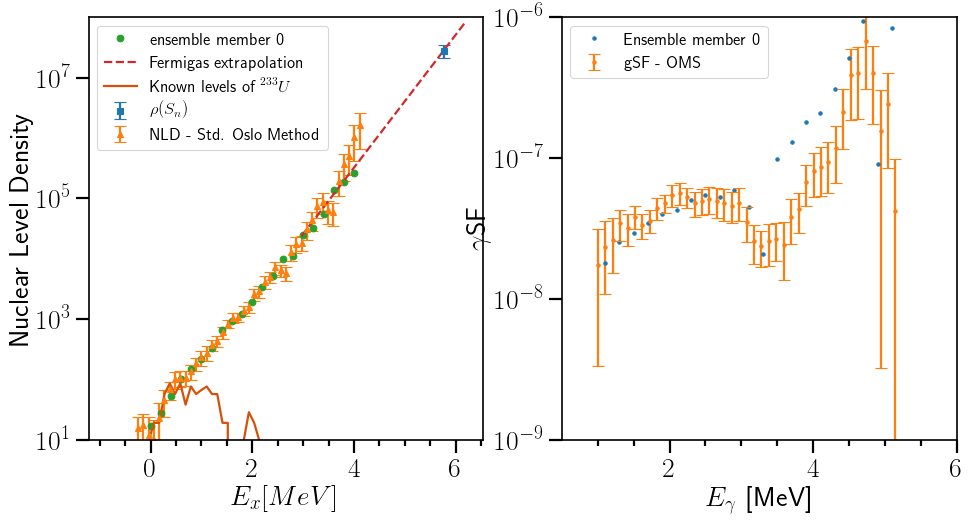

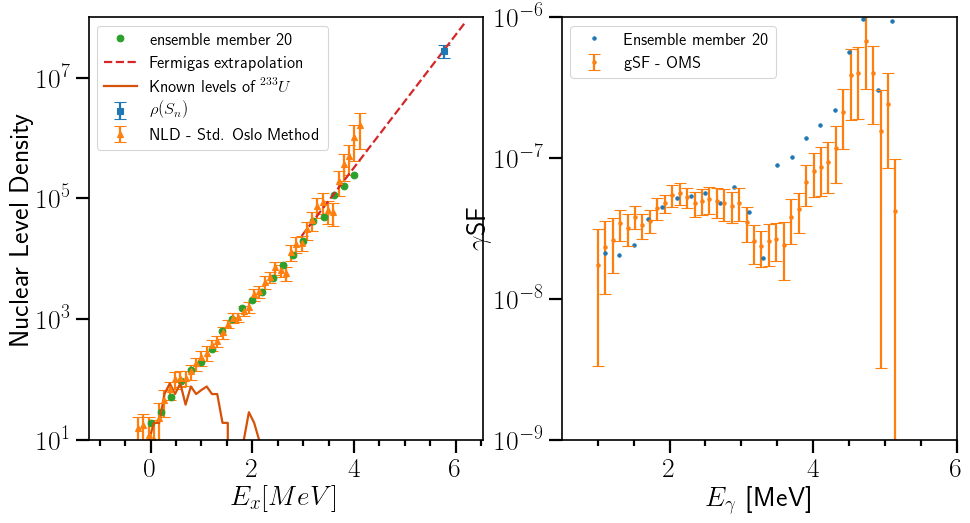

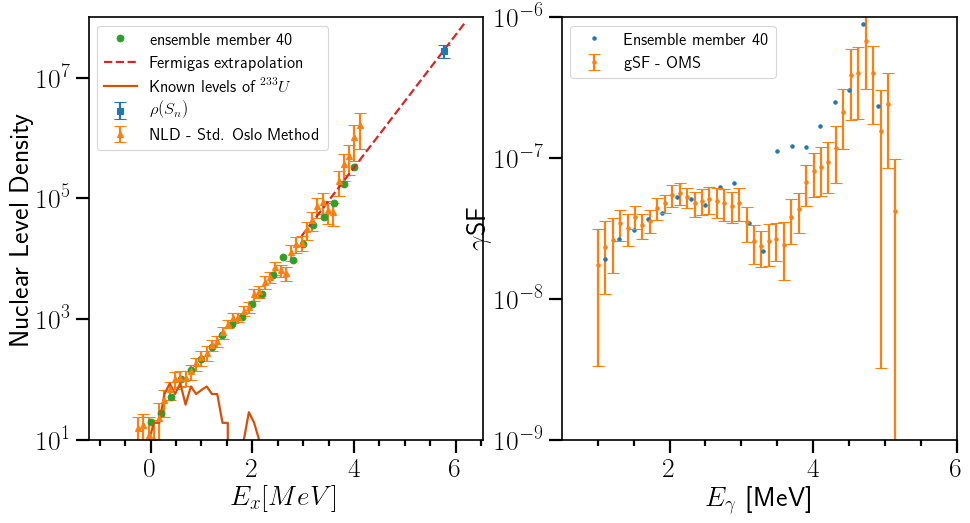

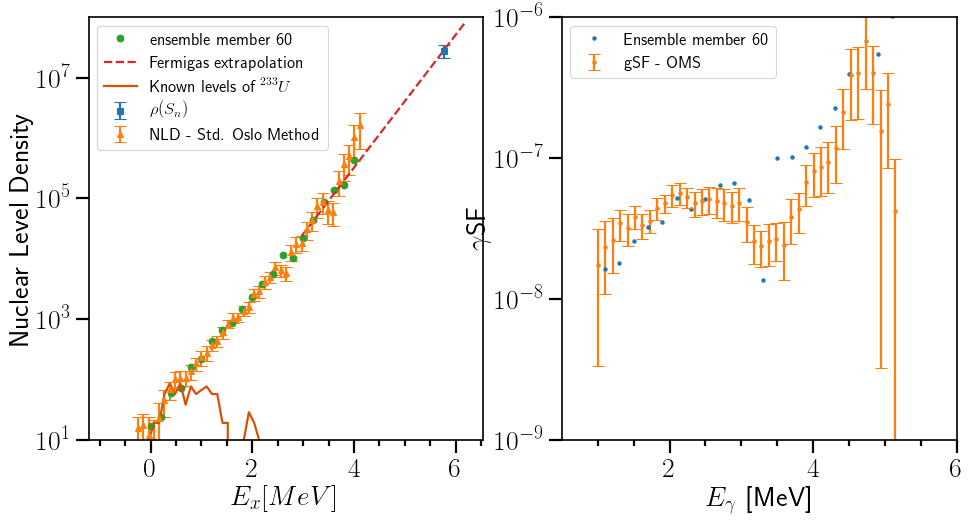

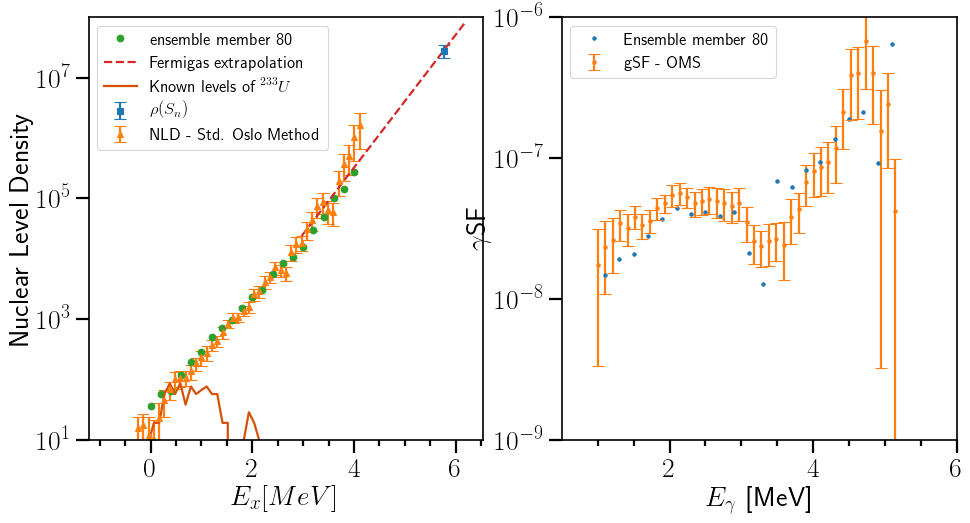

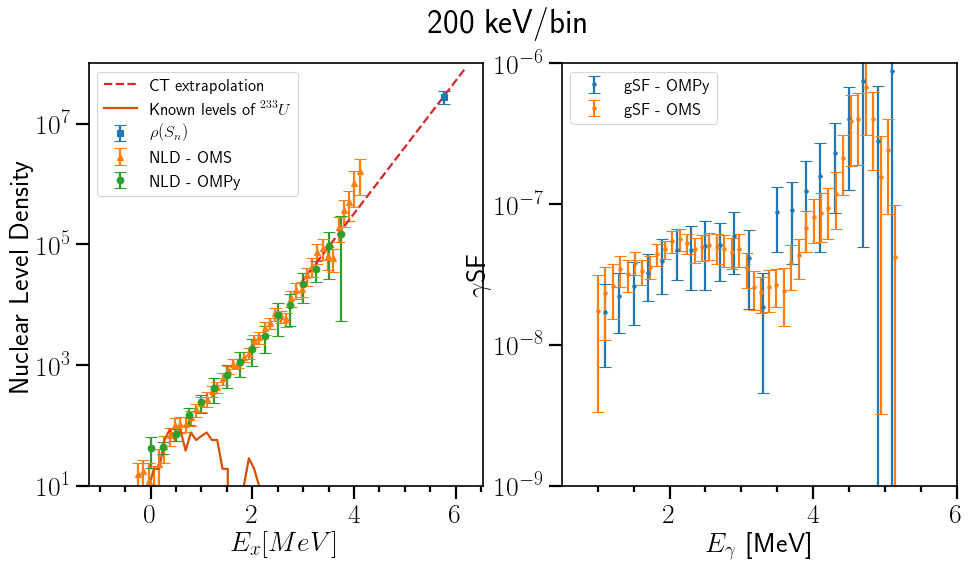

In [23]:
def getMedianQuantile(func):
    "Estimating the 68% confidence interval"
    func = pd.DataFrame(func)
    func_median = pd.DataFrame.median(func)
    func_error_low = func.quantile(0.16)
    func_error_high = func.quantile(0.84)
    func_error = func_error_high - func_error_low
    return func_median, func_error


def plot_gsf_nld(gsf, energy_gsf, nld, energy_nld):
    plt.rcParams["figure.figsize"] = (14,7)
    fig, ax = plt.subplots(1,2)
    ax1 = ax[0]
    ax2 = ax[1]

    #plotting rhoSn
    ax1.errorbar(x=Sn, y=rhoSn, yerr=rhoSn_error, marker='s', linestyle='', label='$\\rho(S_n)$')

    #plotting OMS nld
    ax1.errorbar(x=energy_nld_OMS[:len(nld_OMS)], y=nld_OMS, yerr=nld_OMS_error, marker='^', linestyle='', label='NLD - Std. Oslo Method')

    #plotting OMPy nld
    ax1.plot(energy_nld, nld, marker='o', linestyle='', label='ensemble member %.0i'%i)

    #plotting fermigas extrapolation from OMS
    ax1.plot(energy_nld_OMS[n0_CT:n1_CT], fermigas[n0_CT:n1_CT], linestyle='--', label='Fermigas extrapolation')

    #plotting discrete levels
    ax1.plot(energy_nld_OMS[:len(discrete_levels)], discrete_levels, color="#D65108", label='Known levels of $^{233}U$')

    #plotting gSF
    ax2.plot(energy_gsf, gsf, marker='.', linestyle='', label='Ensemble member %.0i'%i)
    ax2.errorbar(x=energy_gsf_OMS, y=gsf_OMS, yerr=gsf_OMS_error, marker='.', linestyle='', label='gSF - OMS')

    ax1.set_xlabel('$E_x[MeV]$')
    ax1.set_ylabel('Nuclear Level Density')
    ax2.set_ylabel('$\gamma$SF')
    ax2.set_xlabel('$E_\gamma$  [MeV]')
    for j in ax:
        j.legend(fontsize=15)
        j.set_yscale('log')
        j.yaxis.set_minor_locator(AutoMinorLocator())
        j.xaxis.set_minor_locator(AutoMinorLocator())
    ax2.set_xlim(.5, 6)
    ax2.set_ylim(1e-9, 1e-6)
    ax1.set_ylim(1e1, 1e8)

    fig.show()
    plt.rcParams["figure.figsize"] = (10,8)


path = 'analysis/OMPy/normalized_data/U233_2021-'
path_200 = path+'01-26_13:02:13/' #200 keV/bin
path_300 = path+'02-01_17:38:01/' #300 keV/bin
#path_200 = path+'02-01_20:33:48/' 
path_200 = path+'02-02_14:52:29/'
path_200 = path+'02-02_17:57:46/'
path_200 = path+'02-02_20:45:41/'
path = path_200

gsf = []
nld = []
    
for i in range(100-1):
    gsf_plot = pd.read_csv(path+'data/gsf_%.0i.txt'%i, sep=" ", header=None, skiprows=[0, -1])[1]
    gsf.append(gsf_plot)
    nld_plot = pd.read_csv(path+'data/nld_%.0i.txt'%i, sep=" ", header=None, skiprows=[0, -1])[1]
    nld.append(nld_plot)
    energy_gsf = pd.read_csv(path+'data/gsf_%.0i.txt'%i, sep=" ", header=None, skiprows=[0, -1])[0]*1e-3
    energy_nld = pd.read_csv(path+'data/nld_%.0i.txt'%i, sep=" ", header=None, skiprows=[0, -1])[0]*1e-3
    if i % 20 == 0:
        plot_gsf_nld(gsf_plot, energy_gsf, nld_plot, energy_nld)
    
gsf_median, gsf_error = getMedianQuantile(gsf)
nld_median, nld_error = getMedianQuantile(nld)  
energy_gsf = pd.read_csv(path+'data/gsf_0.txt', sep=" ", header=None, skiprows=[0, -1])[0]*1e-3
energy_nld = pd.read_csv(path+'data/nld_0.txt', sep=" ", header=None, skiprows=[0, -1])[0]*1e-3


plt.rcParams["figure.figsize"] = (14,7)
fig, ax = plt.subplots(1,2)
ax1 = ax[0]
ax2 = ax[1]

#plotting neutron separation energy
ax1.errorbar(x=Sn, y=rhoSn, yerr=rhoSn_error, marker='s', linestyle='', label='$\\rho(S_n)$')

#plotting OMS nld
ax1.errorbar(x=energy_nld_OMS[:len(nld_OMS)], y=nld_OMS, yerr=nld_OMS_error, marker='^', linestyle='', label='NLD - OMS')

#plotting OMPy nld
ax1.errorbar(x=OMPyDataFrame.iloc[:,13], y=OMPyDataFrame.iloc[:,14], yerr=OMPyDataFrame.iloc[:,15], marker='o', linestyle='', label = 'NLD - OMPy')

#plotting CT extrapolation from OMS
ax1.plot(energy_nld_OMS[n0_CT:n1_CT], fermigas[n0_CT:n1_CT], linestyle='--', label='CT extrapolation')

#plotting discrete levels
ax1.plot(energy_nld_OMS[:len(discrete_levels)], discrete_levels, color="#D65108", label='Known levels of $^{233}U$')

#plotting gSF
ax2.errorbar(x=energy_gsf, y=gsf_median, yerr=gsf_error, 
                    marker='.', linestyle='', label='gSF - OMPy')
ax2.errorbar(x=energy_gsf_OMS, y=gsf_OMS, yerr=gsf_OMS_error, marker='.', linestyle='', label='gSF - OMS')

ax1.set_xlabel('$E_x[MeV]$')
ax1.set_ylabel('Nuclear Level Density')
ax2.set_ylabel('$\gamma$SF')
ax2.set_xlabel('$E_\gamma$  [MeV]')
for i in ax:
    i.legend(fontsize=15)
    i.set_yscale('log')
    i.yaxis.set_minor_locator(AutoMinorLocator())
    i.xaxis.set_minor_locator(AutoMinorLocator())
ax2.set_xlim(.5, 6)
ax2.set_ylim(1e-9, 1e-6)
ax1.set_ylim(1e1, 1e8)

fig.suptitle('200 keV/bin')
fig.show()
plt.rcParams["figure.figsize"] = (10,8)

In [9]:
#Script to clean up the old OMPy runs, to make the data_for_analysis.csv fit for this notebook

def read_write_OMPy(path):
    """
    Read data from saved OMPy results.
    Results to file
    Calculate median and error of results
    Save results to file
    """
    
    
    infile = open(path+'README.txt', 'r')
    for line in infile:
        values = line.split()
        if not values:
            continue
        if values[0] == 'keV':
            kev_per_bin_wish = float(values[3])
            continue
        if values[0] == 'Ex_min:':
            Ex_min = float(values[1])
            continue
        if values[0] == 'Ex_max:':
            Ex_max = float(values[1])
            continue
        if values[0] == 'Eg_min:':
            Eg_min = float(values[1])
            continue
        if values[0] == 'Eg_max:':
            Eg_max = float(values[1])
            continue
        if values[0] == 'Gg:':
            Gg = float(values[1])
            Gg_err = float(values[3])
            continue
        if values[0] == 'rhoSn:':
            rhoSn = float(values[1])
            rhoSn_err = float(values[3])
    infile.close()
    
    parameter_dict = {'keV_per_bin': kev_per_bin_wish, 'Ex_min': Ex_min, 'Ex_max': Ex_max, 'Eg_min': Eg_min, 'Eg_max': Eg_max, 'Gg': Gg, 'Gg_err': Gg_err, 'rhoSn': rhoSn, 'rhoSn_err': rhoSn_err}
    dataFrame1 = pd.DataFrame(parameter_dict, index=[0])
    
    energy_gsf = pd.read_csv(path+'data/gsf_0.txt', sep=" ", header=None, skiprows=[0, -1])[0]*1e-3
    energy_nld = pd.read_csv(path+'data/nld_0.txt', sep=" ", header=None, skiprows=[0, -1])[0]*1e-3
    gsf = []
    nld = []
    
    for i in range(100-1):
        gsf.append(pd.read_csv(path+'data/gsf_%.0i.txt'%i, sep=" ", header=None, skiprows=[0, -1])[1])
        nld.append(pd.read_csv(path+'data/nld_%.0i.txt'%i, sep=" ", header=None, skiprows=[0, -1])[1])
    
    gsf_median, gsf_error = getMedianQuantile(gsf)
    nld_median, nld_error = getMedianQuantile(nld)
    
    OMPy_dict = {'E_gamma': energy_gsf, 'gSF-median':gsf_median, 'gSF-error': gsf_error, 'E_x': energy_nld, 'NLD-median': nld_median, 'NLD-error': nld_error}
    
    #write to file
    dataFrame2 = pd.DataFrame(OMPy_dict)
    dataFrame = pd.concat([dataFrame1, dataFrame2])
    dataFrame.to_csv(path+'data_for_analysis.csv')

#read_write_OMPy('../analysis/OMPy/normalized_data/U233_INPUT_DATE/')
